# Assignment7
- Implement a DCGAN (https://arxiv.org/abs/1511.06434)
- Train the model to generate CIFAR-like images
- Requirements:
    - Use Tensorboard, WandDB or some other experiment tracker
    - Experiment with input dimensionality
- Extra point:
    - Implmentet WGAN (https://arxiv.org/abs/1701.07875)
    - Use it to generate CIFAR-like images

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Functions
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import random as rand
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time
import pandas as pd
import PIL

In [ ]:
!pip install wandb -q

In [ ]:
import wandb
wandb.login()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: Currently logged in as: sreeni1204 (use `wandb login --relogin` to force relogin)


True

In [ ]:
wandb.init(project="DCGAN")

gen loss,1.06161
dic loss,0.91323
_runtime,3333
_timestamp,1626640374
_step,12


gen loss,▁█████
dic loss,▁▁▁███
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆█
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


# Helpers

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# DCGAN

In [ ]:
class DCGAN_model(nn.Module):

    def __init__(self,
                 generator_map_size,
                 discriminator_map_size,
                 generator_input_size,
                 number_of_channels,
                 model_part="GEN"):
        super(DCGAN_model, self).__init__()
        self.GMS = generator_map_size
        self.DMS = discriminator_map_size
        self.GIS = generator_input_size
        self.CN = number_of_channels
        self.MP = model_part
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.GIS, out_channels=self.GMS*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.GMS*8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.GMS*8, out_channels=self.GMS*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.GMS*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.GMS*4, out_channels=self.GMS*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.GMS*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.GMS*2, out_channels=self.GMS, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.GMS),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.GMS, out_channels=self.CN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=self.CN, out_channels=self.DMS, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=self.DMS, out_channels=self.DMS*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.DMS*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=self.DMS*2, out_channels=self.DMS*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.DMS*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=self.DMS*4, out_channels=self.DMS*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.DMS*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=self.DMS*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def Generator(self, input):
        output = self.generator(input)
        return output

    def Discriminator(self, input):
        output = self.discriminator(input)
        return output

    def forward(self, input):
        if self.MP == "GEN":
            return self.Generator(input)
        elif self.MP == "DIS":
            return self.Discriminator(input)
        else:
            raise NotImplementedError("Check the model type")

In [ ]:
class Trainer(object):

    def __init__(self,
                 net_generator,
                 net_discriminator,
                 train_data_loader,
                 gen_optimizor,
                 dis_optimizor,
                 wandb_config,
                 loss_function,
                 epochs=10):
        super(Trainer, self).__init__()
        self.net_generator = net_generator
        self.net_discriminator = net_discriminator
        self.train_data_loader = train_data_loader
        self.gen_opt = gen_optimizor
        self.dis_opt = dis_optimizor
        self.W_C = wandb_config
        self.loss_function = loss_function
        self.epochs = epochs
        self.net_generator.train()
        self.net_discriminator.train()

    def update_discriminator(self, input_data):
        self.net_discriminator.zero_grad()
        input_data = input_data.to(device)
        batch_size = input_data.size(0)
        label = torch.full((batch_size,), 0.9, device=device)
        output = self.net_discriminator(input_data).view(-1)
        loss = self.loss_function(output, label)
        loss.backward()
        fake_data = output.mean().item()

        noise = torch.randn(batch_size, self.W_C.generator_input_size, 1, 1, device=device)
        fake_images = self.net_generator(noise)
        label.fill_(0.1)
        output = self.net_discriminator(fake_images.detach()).view(-1)
        loss_fake = self.loss_function(output, label)
        loss_fake.backward()
        gen_fake_image = output.mean().item()

        final_loss = loss + loss_fake
        self.dis_opt.step()

        return fake_images, label, final_loss

    def update_generator(self, image, label):
        self.net_generator.zero_grad()
        label.fill_(0.9)
        output = self.net_discriminator(image).view(-1)
        loss = self.loss_function(output, label)
        loss.backward()
        self.gen_opt.step()

        return output, loss

    def train(self, epoch):
        i = 0
        for image, _ in self.train_data_loader:
            fake_images, label, loss_disc = self.update_discriminator(image)
            output, loss_gen = self.update_generator(fake_images, label)
            if i % 100 == 0 and epoch % 10 == 0:
                print(f"    iters: {i}, gen loss: {loss_gen.item()}, dic loss: {loss_disc.item()}")
                wandb.log({"gen loss": loss_gen.item(),
                           "dic loss": loss_disc.item()})
            i += 1

    def model_fit(self):
        image_list = []
        noise = torch.randn(64, self.W_C.generator_input_size, 1, 1, device=device)
        print("Training started")
        for epoch in range(self.epochs):
            if epoch % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{self.epochs}:")
            self.train(epoch)
            if epoch % 10 == 0:
                with torch.no_grad():
                    fake_image = self.net_generator(noise).detach().cpu()
                image_list.append(wandb.Image(torchvision.utils.make_grid(fake_image, padding=2, normalize=True)))
                wandb.log({"generated images": image_list})
        print("Training ended")

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
wandb.watch_called = False
config = wandb.config
config.batchsize = 128
config.epochs = 30
config.learningrate = 0.002
config.device = device
config.generator_input_size = 100
config.beta = 0.5
config.seed = 42
config.log_interval = 10

In [ ]:
def weight_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

In [ ]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = dsets.CIFAR10(root='./data',
                              train=True,
                              transform=transform,
                              download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=config.batchsize, 
                                           shuffle=True)

Files already downloaded and verified


In [ ]:
net_generator = DCGAN_model(generator_map_size=64,
                            discriminator_map_size = 64,
                            generator_input_size = config.generator_input_size,
                            number_of_channels = 3,
                            model_part="GEN"
                            ).to(device)
net_generator.apply(weight_init)

net_discriminator = DCGAN_model(generator_map_size=64,
                            discriminator_map_size = 64,
                            generator_input_size = config.generator_input_size,
                            number_of_channels = 3,
                            model_part="DIS"
                            ).to(device)
net_discriminator.apply(weight_init)

DCGAN_model(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()

In [ ]:
loss_function = nn.BCELoss()
gen_optimizor = torch.optim.Adam(net_generator.parameters(), lr=config.learningrate, betas=(config.beta, 0.999))
dis_optimizor = torch.optim.Adam(net_discriminator.parameters(), lr=config.learningrate, betas=(config.beta, 0.999))

wandb.watch(net_generator, log='all')
wandb.watch(net_discriminator, log='all')

model_train = Trainer(net_generator=net_generator,
                      net_discriminator=net_discriminator,
                      train_data_loader=train_loader,
                      gen_optimizor=gen_optimizor,
                      dis_optimizor=dis_optimizor,
                      wandb_config=config,
                      loss_function=loss_function,
                      epochs=config.epochs)

model_train.model_fit()

torch.save(net_generator.state_dict(), "gen_model.h5")
wandb.save("gen_model.h5")

Training started
Epoch 1/30:
    iters: 0, gen loss: 17.385833740234375, dic loss: 1.6079914569854736
    iters: 100, gen loss: 1.4770722389221191, dic loss: 1.478977084159851
    iters: 200, gen loss: 1.4076402187347412, dic loss: 1.5767651796340942
    iters: 300, gen loss: 0.7919889688491821, dic loss: 1.9650872945785522
Epoch 11/30:
    iters: 0, gen loss: 1.0798375606536865, dic loss: 1.1557278633117676
    iters: 100, gen loss: 1.3518760204315186, dic loss: 1.1986054182052612
    iters: 200, gen loss: 1.8125741481781006, dic loss: 1.404104471206665
    iters: 300, gen loss: 1.221498727798462, dic loss: 1.2683329582214355
Epoch 21/30:
    iters: 0, gen loss: 2.056257724761963, dic loss: 0.7125343084335327
    iters: 100, gen loss: 1.6672849655151367, dic loss: 0.945235550403595
    iters: 200, gen loss: 2.285928964614868, dic loss: 1.0545845031738281
    iters: 300, gen loss: 2.4205331802368164, dic loss: 0.741040825843811
Training ended


['/content/wandb/run-20210717_193456-2nam041j/files/gen_model.h5']

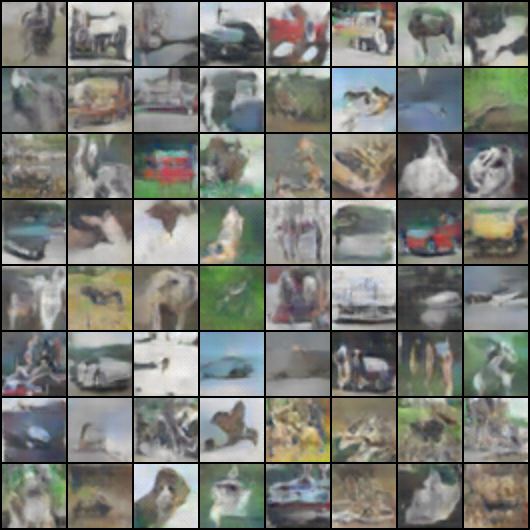

Above we have implemented the DCGAN. We have used WandB for recording the results of experiment. The weights for the convolution blocks are initialized by normal distribution with mean as 0 and std as 0.02. The results and loss curves can be seen in WandB website (I am not sure how to share the results stored). 

**The discriminator** which learns how to distinguish fake from real objects of the type we’d like to create. It uses batch norm layers and LeakyReLU activations.

**The generator** which creates new content and tries to fool the discriminator. It uses ReLU activations

**Input and Ouput**
The input is a latent vector drawn from a standard normal distribution and the output is a 3 x 32 x 32 RGB image.


As we can see above the loss of discriminator and generator decreases, and are of lower values. The generator generates images from noise that are almost similar to the training data.

Above we can see some of the generated images.

# WGAN

In [ ]:
wandb.init(project="WGAN")

In [ ]:
class WGAN_trainer():

    def __init__(self,
                 net_generator,
                 net_discriminator,
                 train_data_loader,
                 gen_optimizor,
                 dis_optimizor,
                 wandb_config,
                 loss_function,
                 epochs=10):
        super(WGAN_trainer, self).__init__()
        self.net_generator = net_generator
        self.net_discriminator = net_discriminator
        self.train_data_loader = train_data_loader
        self.gen_opt = gen_optimizor
        self.dis_opt = dis_optimizor
        self.W_C = wandb_config
        self.loss_function = loss_function
        self.epochs = epochs
        self.net_generator.train()
        self.net_discriminator.train()

    def update_discriminator(self, input_data_iter, i):
        Diters = 200
        input = torch.FloatTensor(64, 3, 64, 64).to(device)
        for param in self.net_discriminator.parameters():
            param.requires_grad = True

        j = 0
        while j < Diters and i < len(self.train_data_loader):
            j += 1

            for param in self.net_discriminator.parameters():
                param.data.clamp_(-0.01, 0.01)
            
            input_data = input_data_iter.next()
            i += 1
            input_data = input_data[0].to(device)
            batch_size = input_data.size(0)
            label = torch.full((batch_size,), 0.9, device=device)
            output = self.net_discriminator(input_data).view(-1)
            loss = self.loss_function(output, label)
            loss.backward()
            # fake_data = output.mean().item()

            noise = torch.randn(batch_size, self.W_C.generator_input_size, 1, 1, device=device)
            fake_images = self.net_generator(noise)
            label.fill_(0.1)
            output = self.net_discriminator(fake_images.detach()).view(-1)
            loss_fake = self.loss_function(output, label)
            loss_fake.backward()
            # gen_fake_image = output.mean().item()

            final_loss = loss + loss_fake
            self.dis_opt.step()

        return fake_images, label, final_loss, i+1

    def update_generator(self, label):
        for param in self.net_discriminator.parameters():
            param.requires_grad = False
        
        self.net_generator.zero_grad()
        noise = torch.randn(self.W_C.batchsize, self.W_C.generator_input_size, 1, 1, device=device)
        fake_images = self.net_generator(noise)
        label.fill_(0.9)
        output = self.net_discriminator(fake_images).view(-1)
        loss = self.loss_function(output, label)
        loss.backward()
        self.gen_opt.step()

        return loss

    def model_fit(self):
        image_list = []
        noise = torch.randn(64, self.W_C.generator_input_size, 1, 1, device=device)
        print("Training started")
        for epoch in range(self.epochs):
            data_iter = iter(self.train_data_loader)
            i = 0
            while i < len(self.train_data_loader):
                _, label, disc_loss, i = self.update_discriminator(data_iter, i)
                gen_loss = self.update_generator(label)
            if epoch % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{self.epochs}:")
                print(f"    gen loss: {gen_loss}, disc loss: {disc_loss}")
                wandb.log({"gen loss": gen_loss,
                           "dic loss": disc_loss})
            if epoch % 10 == 0:
                with torch.no_grad():
                    fake_image = self.net_generator(noise).detach().cpu()
                image_list.append(wandb.Image(torchvision.utils.make_grid(fake_image, padding=2, normalize=True)))
                wandb.log({"generated images": image_list})
        print("Training ended")

In [ ]:
wandb.watch_called = False
config = wandb.config
config.batchsize = 64
config.epochs = 30
config.learningrate = 0.00005
config.device = device
config.generator_input_size = 100
config.beta = 0.5
config.seed = 42
config.log_interval = 10

In [ ]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = dsets.CIFAR10(root='./data',
                              train=True,
                              transform=transform,
                              download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=config.batchsize, 
                                           shuffle=True)

Files already downloaded and verified


In [ ]:
net_generator = DCGAN_model(generator_map_size=64,
                            discriminator_map_size = 64,
                            generator_input_size = config.generator_input_size,
                            number_of_channels = 3,
                            model_part="GEN"
                            ).to(device)
net_generator.apply(weight_init)

net_discriminator = DCGAN_model(generator_map_size=64,
                            discriminator_map_size = 64,
                            generator_input_size = config.generator_input_size,
                            number_of_channels = 3,
                            model_part="DIS"
                            ).to(device)
net_discriminator.apply(weight_init)

DCGAN_model(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()

In [ ]:
loss_function = nn.BCELoss()
gen_optimizor = torch.optim.RMSprop(net_generator.parameters(), lr=config.learningrate)
dis_optimizor = torch.optim.RMSprop(net_discriminator.parameters(), lr=config.learningrate)

wandb.watch(net_generator, log='all')
wandb.watch(net_discriminator, log='all')

model_train = WGAN_trainer(net_generator=net_generator,
                            net_discriminator=net_discriminator,
                            train_data_loader=train_loader,
                            gen_optimizor=gen_optimizor,
                            dis_optimizor=dis_optimizor,
                            wandb_config=config,
                            loss_function=loss_function,
                            epochs=config.epochs)

model_train.model_fit()

torch.save(net_generator.state_dict(), "gen_model.h5")
wandb.save("gen_model.h5")

Training started
Epoch 1/30:
    gen loss: 1.060736894607544, disc loss: 0.9135668277740479
Epoch 11/30:
    gen loss: 1.061514139175415, disc loss: 0.9131316542625427
Epoch 21/30:
    gen loss: 1.0616092681884766, disc loss: 0.9132254719734192
Training ended


['/content/wandb/run-20210718_193721-1n913pcj/files/gen_model.h5',
 '/content/wandb/run-20210718_193721-1n913pcj/files/gen_model.h5']

Here we have implemented WGAN with DCGAN's generator and discriminator. Here the weights for the convolution blocks are initialized by normal distribution with mean as 0 and std as 0.02. The weights of the discriminator are clamped between -0.01 and 0.01. Here the discriminator is executed more times than the generator. 

The implementation has some flaws, in the calculation of loss for optimizing the generations of the images. The generator generates images, but need some tuning for proper generation. I also suspect the way of storing the image grid into WandB.

# References

- DCGAN: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- WGAN: https://github.com/martinarjovsky/WassersteinGAN